In [1]:
import json
import torch

from utils import init_sequential

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import quad

import gc

torch.set_grad_enabled(False)

ROOT = Path('model')
ARCH = Path('arch')

FIGURES = Path('figures')
FIGURES_PRED = FIGURES / 'pred/'
FIGURES_EIGV = FIGURES / 'eigv/'
FIGURES_BASIS = FIGURES / 'basis/'
FIGURES_KERNEL = FIGURES / 'kernel/'
FIGURES_ERROR = FIGURES / 'error/'

FIGURES_PRED.mkdir(exist_ok=True, parents=True)
FIGURES_EIGV.mkdir(exist_ok=True, parents=True)
FIGURES_BASIS.mkdir(exist_ok=True, parents=True)
FIGURES_KERNEL.mkdir(exist_ok=True, parents=True)
FIGURES_ERROR.mkdir(exist_ok=True, parents=True)

name = 'S2_qs100_raw'
epoch = 2_500

with open(ARCH / f'{name}.json', 'r') as f:
    params = json.load(f)

PATH = ROOT / params['name']

savefig = True
MODEL_PREFIX = r'$S^2_{\theta}$'

FIGURES_PREFIX = f'{params["name"]}_epoch{epoch}'
plt.rc('font', size=14)
plt.rc('lines', linewidth=2)

# FIGURES_PREFIX = f'{params["name"]}_epoch{epoch}_slide'
# plt.rc('font', size=16)
# plt.rc('lines', linewidth=4)

In [2]:
K = init_sequential(
    params['layers'],
    params['finish_with_activation'])

data = torch.load(PATH / f'{epoch}.model')

K.load_state_dict(data['K'][0])

<All keys matched successfully>

In [3]:
match params['quad-name']:
    case 'gaussian':
        int_p, int_w = quad.gaussian_quadrature(0, 1, params['quad-size'])
    case 'trapezoidal':
        int_p, int_w = quad.trapezoidal_rule(0, 1, params['quad-size'])
    case _:
        int_p, int_w = quad.trapezoidal_rule(0, 1, params['quad-size'])

In [4]:
print(K)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): PAU(m=5, n=4, efficient=True)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): PAU(m=5, n=4, efficient=True)
  (4): Linear(in_features=100, out_features=1, bias=True)
)


In [5]:
def model(xb, t):
    t1, t2 = torch.meshgrid(int_p, t, indexing='xy')
    t1t2 = torch.stack((t1, t2)).reshape(2, -1)
    Kt1t2 = K(t1t2.T).reshape((len(t), len(int_p)))
    return torch.einsum('bj,ij,j->bi', xb, Kt1t2, int_w)
    # n = len(t)
    # m = xb.shape[1]
    # int_p_aux, int_w_aux = quad.trapezoidal_rule(0, 1, m)
    
    # result = torch.zeros(xb.shape[0], n)
    # for j, t2 in enumerate(t):
    #     t1t2 = torch.stack((int_p_aux, t2.expand(m))).T
    #     Kt1t2 = K(t1t2).squeeze()

    #     for i, xi in enumerate(xb):
    #         result[i, j] += (xi * Kt1t2) @ int_w_aux
        
    # return result

/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


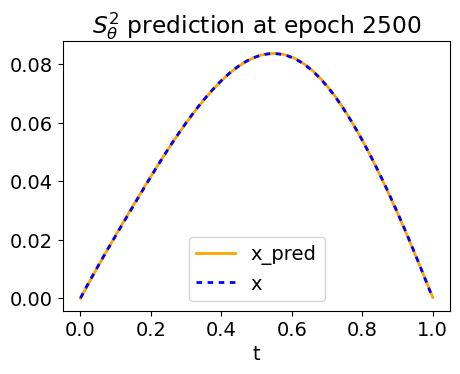

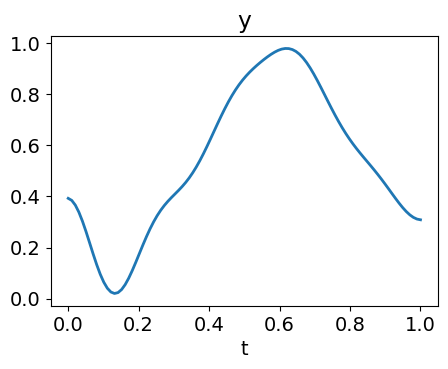

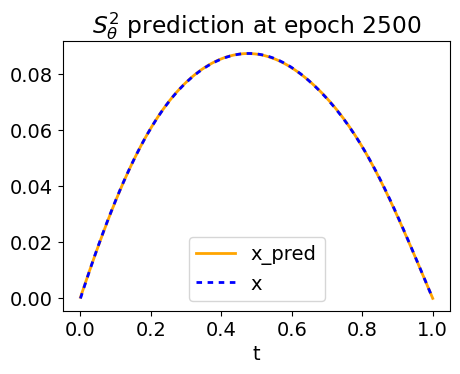

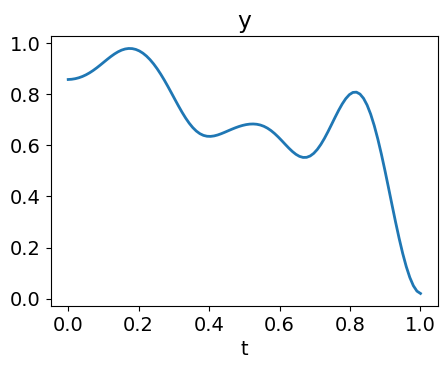

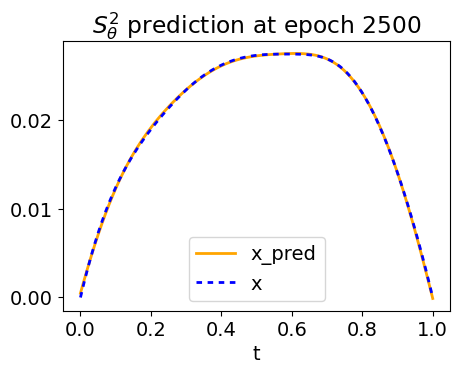

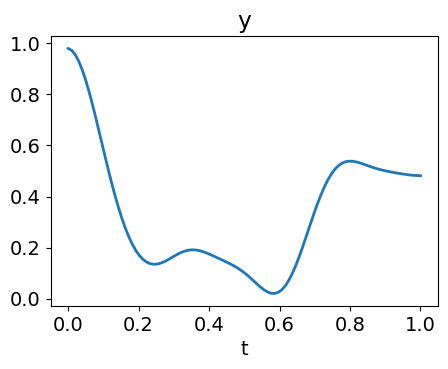

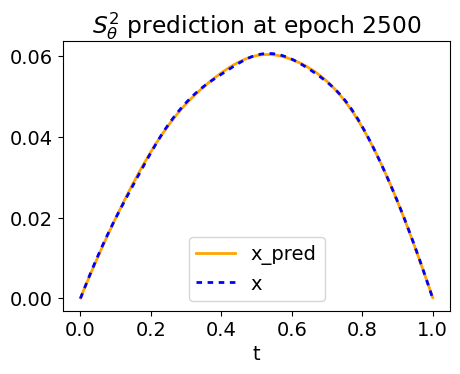

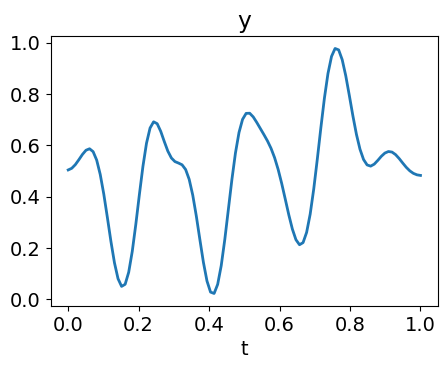

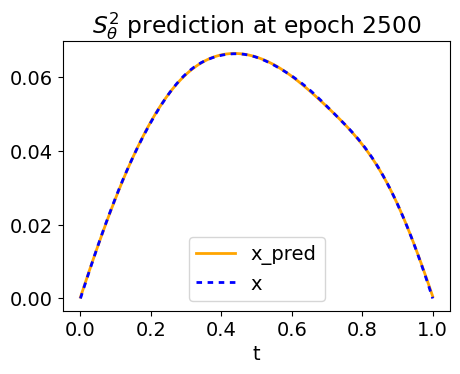

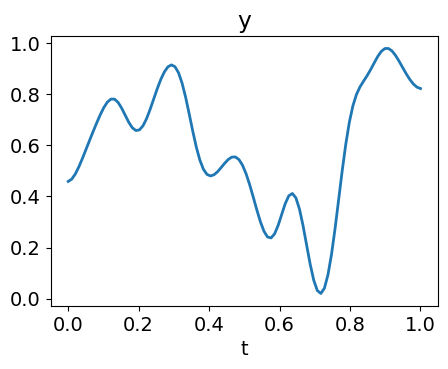

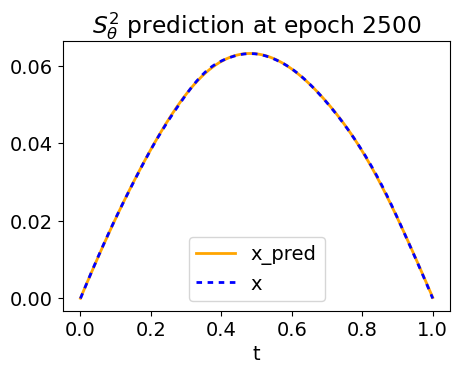

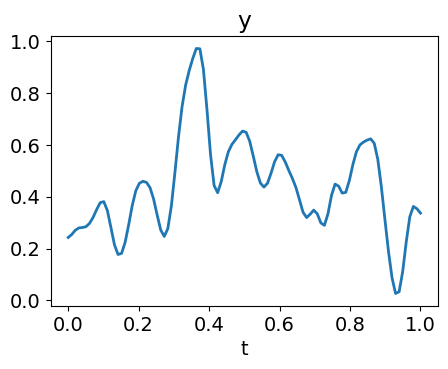

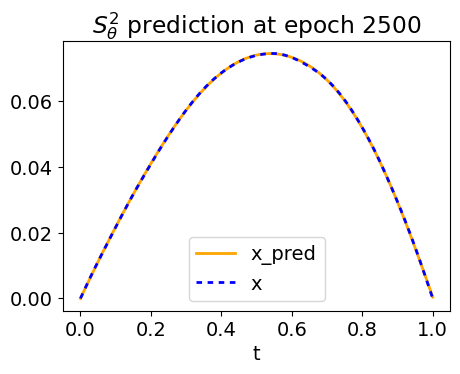

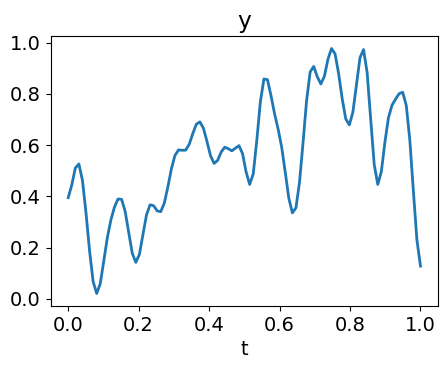

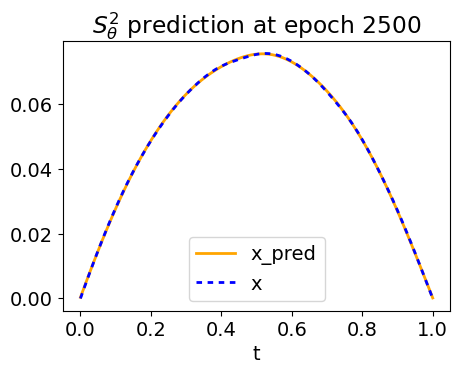

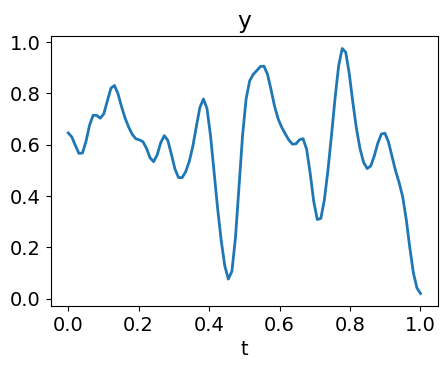

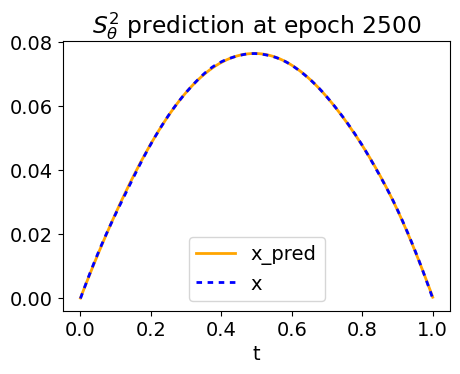

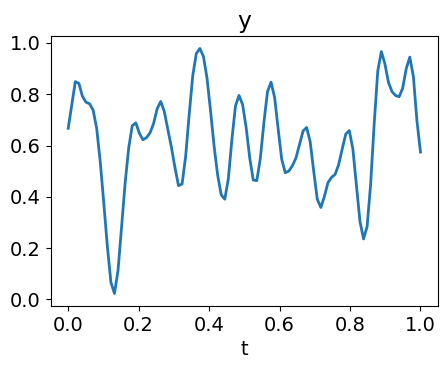

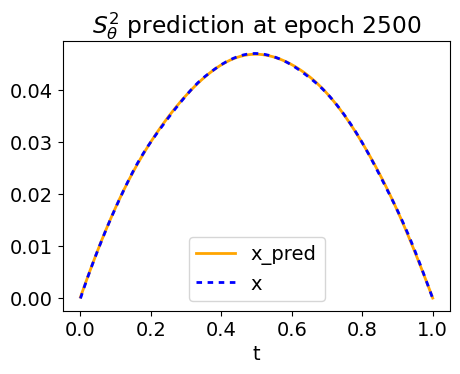

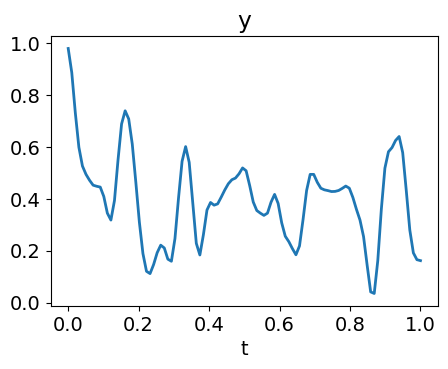

In [6]:
x_ds, y_ds = torch.load(PATH / 'valid.ds')
size = len(x_ds)
step = size // 10

N = 200
t = torch.linspace(0, 1, N)
for i, idx in enumerate(range(0, size, step)):
    Y = torch.load(f'dataset/ds20k/valid/{i}_Y.pt')
    X = torch.load(f'dataset/ds20k/valid/{i}_X.pt')

    ip = torch.linspace(0, 1, len(X)).numpy()
    
    x_pred = model(x_ds[idx].unsqueeze(dim=0), int_p).squeeze()
    
    plt.figure(figsize=(5, 3.5))
    plt.plot(int_p, x_pred, c='orange', label='x_pred')
    plt.plot(int_p, y_ds[idx], 'b--', dashes=[2], label='x')

    plt.xlabel('t')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_Fig{i}.png', bbox_inches = 'tight')
    plt.title(MODEL_PREFIX + f' prediction at epoch {epoch}')
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_Fig{i}_with_title.png', bbox_inches = 'tight')
    plt.show()

    plt.figure(figsize=(5, 3.5))
    plt.plot(int_p, x_ds[idx], label='y')
    plt.xlabel('t')
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_y_Fig{i}.png', bbox_inches = 'tight')
    plt.title('y')
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_y_Fig{i}_with_title.png', bbox_inches = 'tight')
    plt.show()

    plt.close('all')
    gc.collect(2)

# Kernel

In [7]:
def compute_ticks(a):
    return [a.min(), a.mean(), a.max()]

In [8]:
N = 200
t = torch.linspace(0, 1, N)
tt = torch.stack(torch.meshgrid((t, t), indexing='xy')).reshape(2,-1)

_, int_w_aux = quad.trapezoidal_rule(0, 1, N)

Real_basis = []
for k in range(1, 9):
    den = torch.sin(torch.pi*k*int_p)**2 @ int_w
    Real_basis.append(torch.sin(torch.pi*k*t) / den)

Real_basis = torch.tensor(np.array(Real_basis)).float()
Real_eigv = [
    1/(torch.pi*k)**2
    for k in range(1, 9)
]

#  Gram-Schmidt
V = Real_basis
n = len(V)
Q = [None for _ in range(n)]
R = [[0.0 for __ in range(n)] for _ in range(n)]

_, int_w_aux = quad.trapezoidal_rule(0, 1, N)
for i in range(n):
    R[i][i] = torch.sqrt(V[i] * V[i] @ int_w_aux)
    Q[i] = V[i] / R[i][i]
    for j in range(i+1, n):
        R[i][j] = V[j] * Q[i] @ int_w_aux
        if abs(R[i][j]) >= 1e-1:
            V[j] = V[j] - (Q[i] * R[i][j])
#  End Gram-Schmidt

Real_basis = np.array(Q)

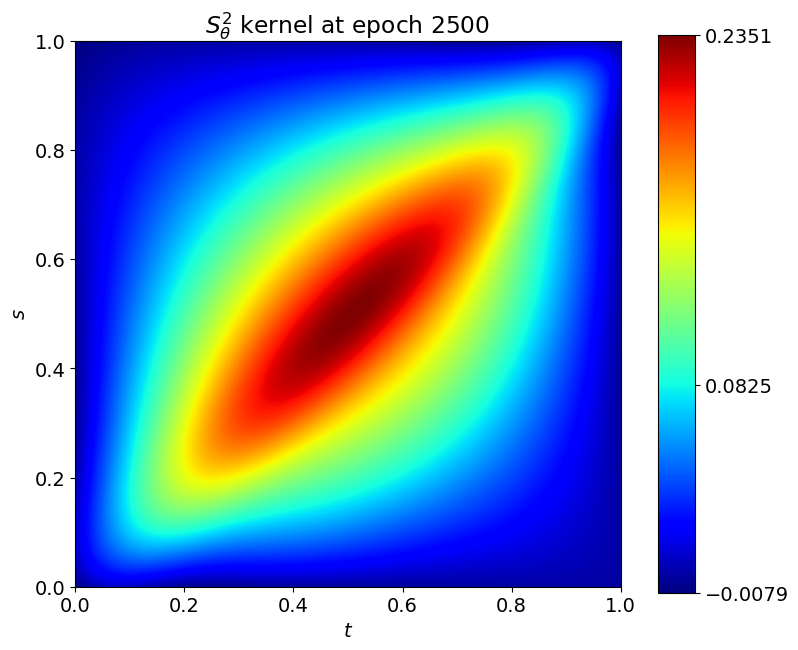

In [9]:
# savefig=True
k = K(tt.T).reshape(N, N)

plt.figure(figsize=(8, 8))
plt.imshow(k.flip(0), cmap='jet', extent=[0, 1, 0, 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$s$')
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{FIGURES_PREFIX}.png', bbox_inches='tight')
plt.colorbar(location='right', aspect=15, fraction=0.06, pad=0.06, ticks=compute_ticks(k))
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{FIGURES_PREFIX}_with_cbar.png', bbox_inches='tight')
plt.title(MODEL_PREFIX + f' kernel at epoch {epoch}')
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{FIGURES_PREFIX}_with_cbar_with_title.png', bbox_inches='tight')
plt.show()

# Kernel2Basis

In [10]:
U, S, _ = torch.linalg.svd(k)

In [11]:
def compute_EIGV(BASIS):
    EIGV = []
    for i, b in enumerate(BASIS):
        benc = np.interp(np.linspace(0, 1, params['quad-size']), t, b)
        bint = torch.tensor(np.interp(int_p, t, b)).float()
        num = (bint * model(torch.tensor(benc).float().unsqueeze(dim=0), int_p)) @ int_w
        den = (bint * bint) @ int_w
        EIGV.append(num / den)
    
    return torch.tensor(EIGV)

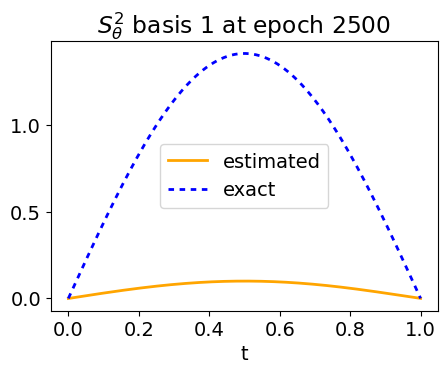

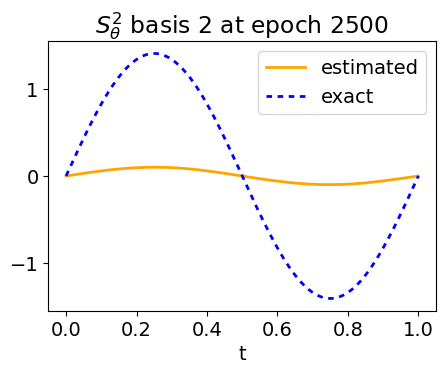

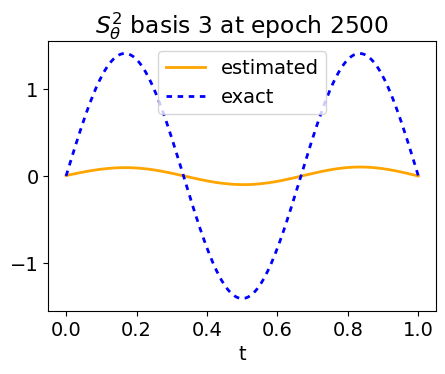

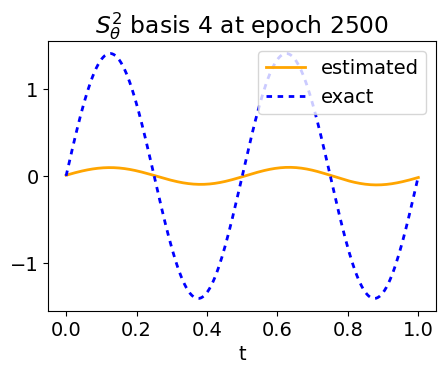

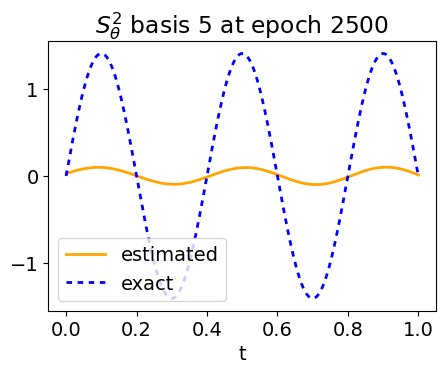

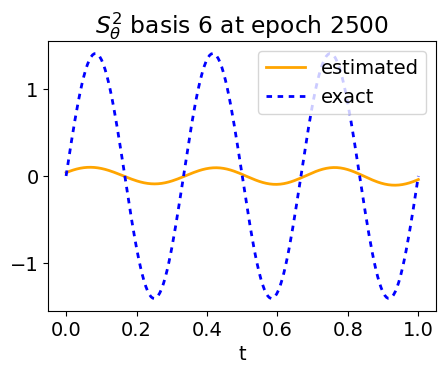

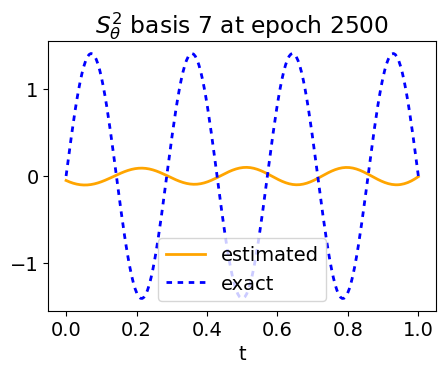

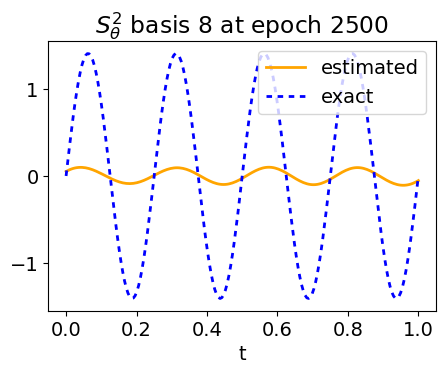

In [12]:
BASIS = U.T[:8]
EIGV = compute_EIGV(BASIS)

idx = torch.argsort(EIGV, descending=True)

EIGV = EIGV[idx]
BASIS = BASIS[idx]

for i, b in enumerate(BASIS):
    plt.figure(figsize=(5, 3.5))
    plt.plot(t, b, c='orange', label='estimated')
    plt.plot(t, Real_basis[i], 'b--', dashes=[2], label='exact')

    plt.xlabel('t')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_Fig{i}.png', bbox_inches='tight')
    plt.title(MODEL_PREFIX + f' basis {i+1} at epoch {epoch}')
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_Fig{i}_with_title.png', bbox_inches='tight')
    plt.show()

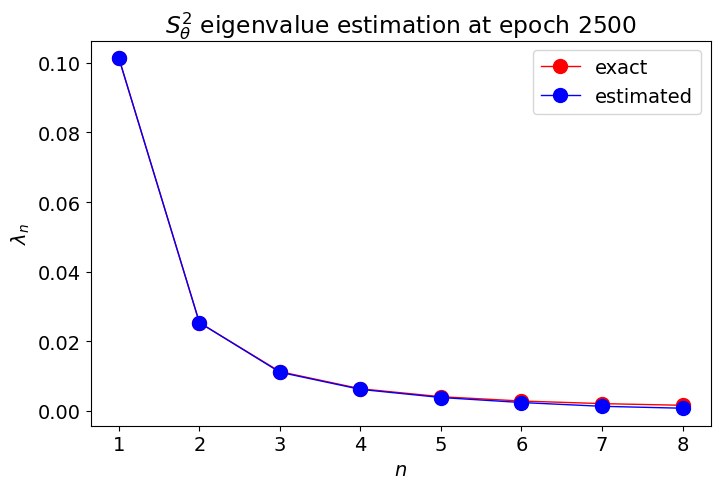

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(list(range(1, 9)), 
         [1/(torch.pi*k)**2 for k in range(1, len(BASIS)+1)], 
         'or-', label='exact',
        markersize=10, linewidth=1)
plt.plot(list(range(1, 9)), EIGV, 'ob-',label='estimated',
        markersize=10, linewidth=1)
plt.legend()
plt.ylabel(r'$\lambda_n$')
plt.xlabel(r'$n$')
if savefig:
    plt.savefig(FIGURES_EIGV / f'{params["name"]}_epoch{epoch}.png', bbox_inches='tight')
plt.title(MODEL_PREFIX + f' eigenvalue estimation at epoch {epoch}')
if savefig:
    plt.savefig(FIGURES_EIGV / f'{FIGURES_PREFIX}_with_title.png', bbox_inches='tight')
plt.show()

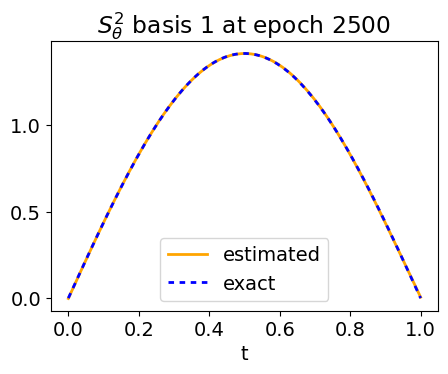

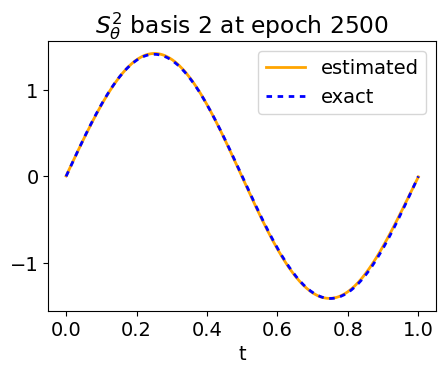

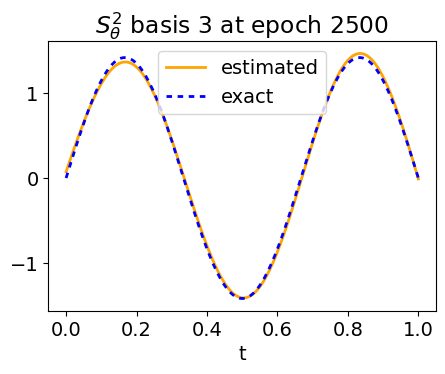

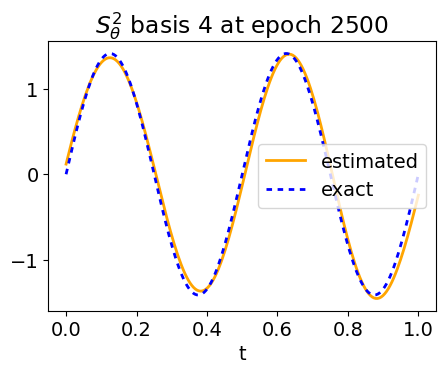

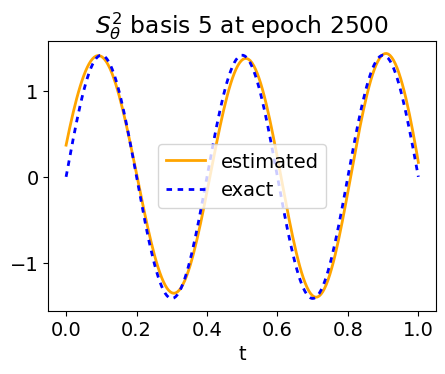

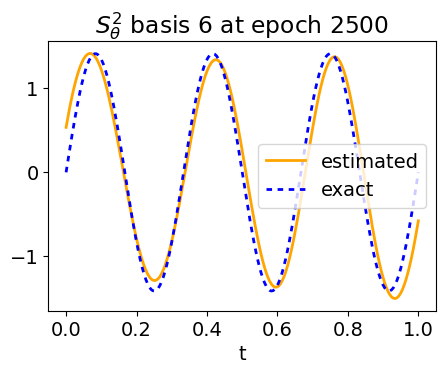

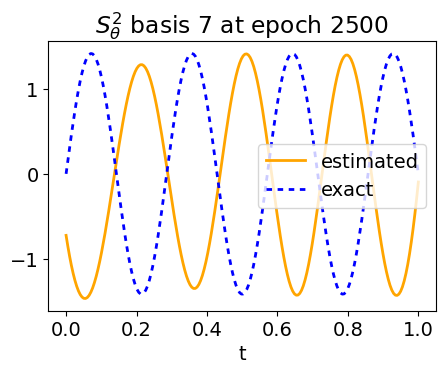

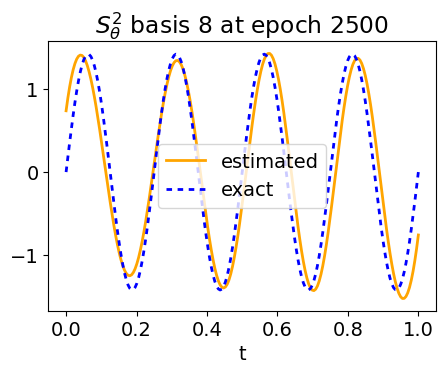

In [14]:
#  Gram-Schmidt
V = BASIS
n = len(V)
Q = [None for _ in range(n)]
R = [[0.0 for __ in range(n)] for _ in range(n)]

for i in range(n):
    R[i][i] = torch.sqrt(V[i] * V[i] @ int_w_aux)
    Q[i] = V[i] / R[i][i]
    for j in range(i+1, n):
        R[i][j] = V[j] * Q[i] @ int_w_aux
        if abs(R[i][j]) >= 1e-1:
            V[j] = V[j] - (Q[i] * R[i][j])
#  End Gram-Schmidt

O_BASIS = torch.stack(Q)
O_EIGV = compute_EIGV(O_BASIS)

idx = torch.argsort(O_EIGV, descending=True)

O_EIGV = O_EIGV[idx]
O_BASIS = O_BASIS[idx]

for i, b in enumerate(O_BASIS):
    plt.figure(figsize=(5, 3.5))
    plt.plot(t, b, c='orange', label='estimated')
    plt.plot(t, Real_basis[i], 'b--', dashes=[2], label='exact')

    plt.xlabel('t')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_orth_Fig{i}.png', bbox_inches='tight')
    plt.title(MODEL_PREFIX + f' basis {i+1} at epoch {epoch}')
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_orth_Fig{i}_with_title.png', bbox_inches='tight')
    plt.show()

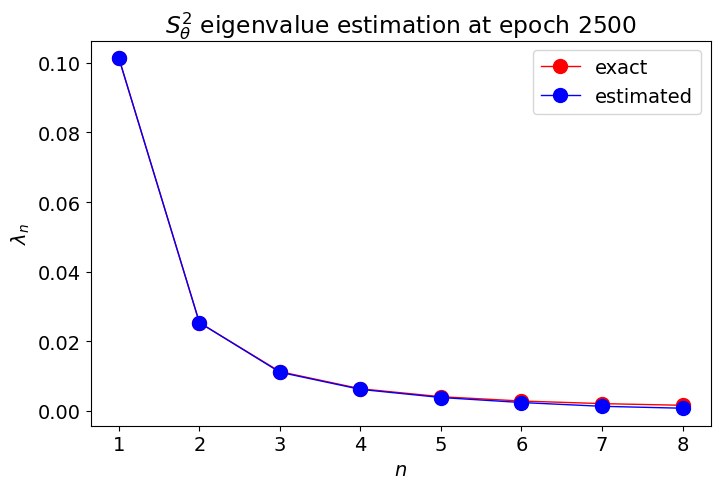

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(list(range(1, 9)), [1/(torch.pi*k)**2 for k in range(1, len(O_BASIS)+1)],
         'or-', label='exact',
        markersize=10, linewidth=1)
plt.plot(list(range(1, 9)), O_EIGV, 'ob-', label='estimated',
        markersize=10, linewidth=1)
plt.legend()
plt.ylabel(r'$\lambda_n$')
plt.xlabel(r'$n$')
if savefig:
    plt.savefig(FIGURES_EIGV / f'{params["name"]}_orth_epoch{epoch}.png', bbox_inches='tight')
plt.title(MODEL_PREFIX + f' eigenvalue estimation at epoch {epoch}')
if savefig:
    plt.savefig(FIGURES_EIGV / f'{FIGURES_PREFIX}_orth_with_title.png', bbox_inches='tight')
plt.show()

In [16]:
def read_error_log(logfile, rf, maxepoch=float('infinity')):
    error = []
    with open(logfile, 'r') as f:
        for line in f:
            ep, err = line.strip().split(',')
            ep = int(ep)
            err = float(err)

            if ep > maxepoch:
                break
            
            if ep % rf == 0:
                error.append(err)
    return error

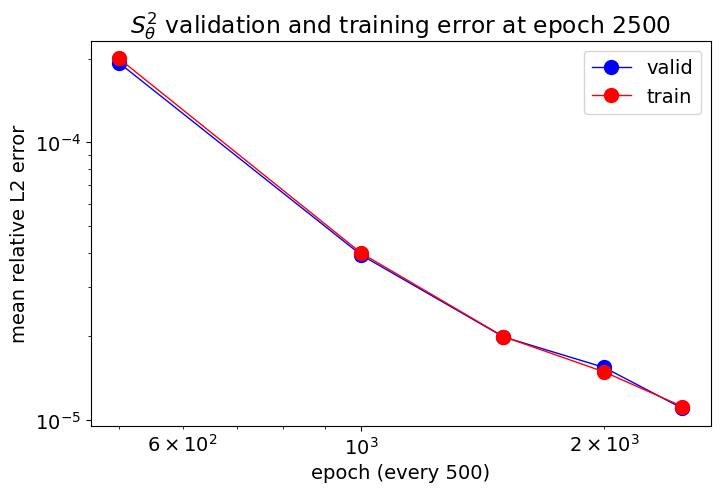

<Figure size 800x500 with 0 Axes>

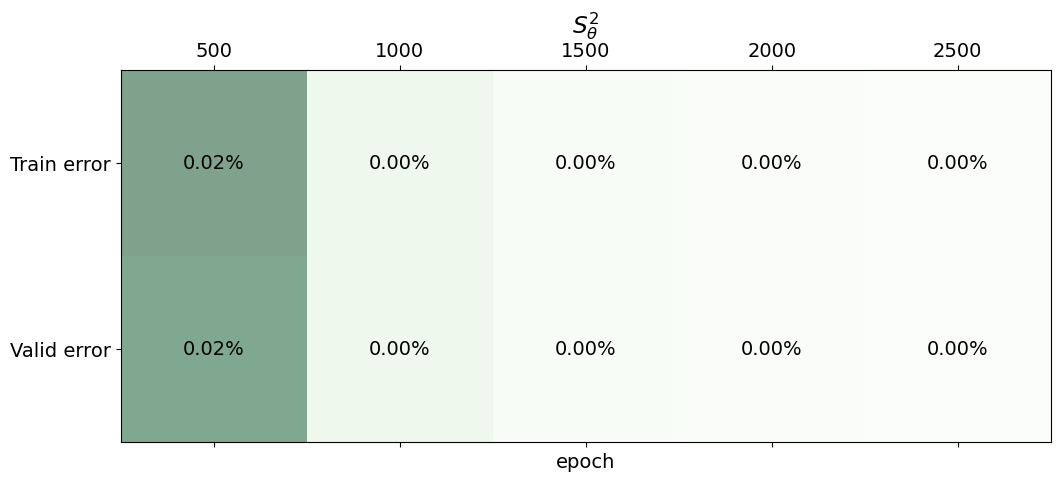

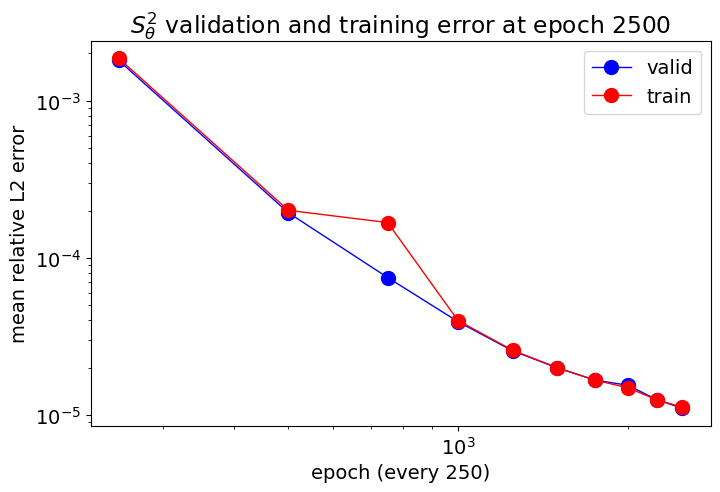

<Figure size 800x500 with 0 Axes>

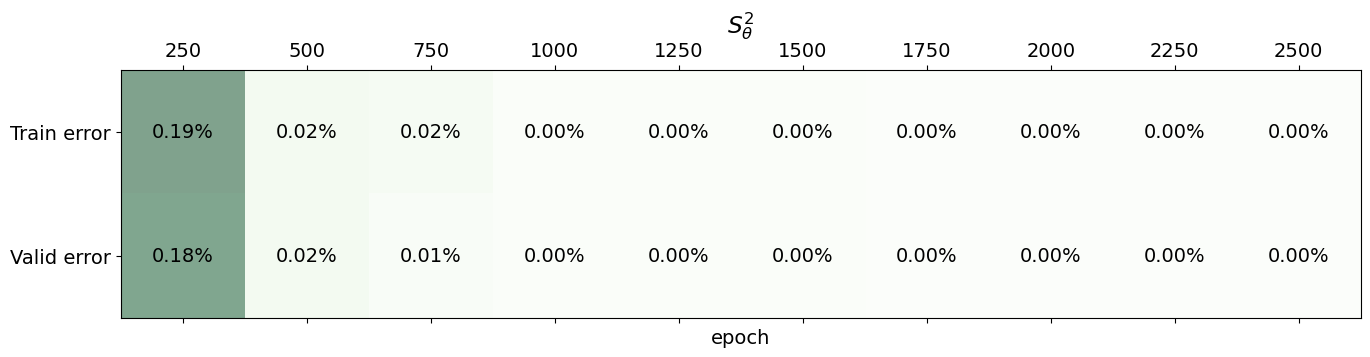

In [17]:
for rf_ in [5, 10]:
    rf = epoch // rf_
    timeline = [i for i in range(rf, epoch+rf, rf)]
    
    valid_error = read_error_log(PATH / 'valid.error', rf, maxepoch=epoch)
    train_error = read_error_log(PATH / 'train.error', rf, maxepoch=epoch)

    ##  PLOT
    plt.figure(figsize=(8, 5))
    plt.loglog(timeline, valid_error, '-ob', label='valid', markersize=10, linewidth=1)
    plt.loglog(timeline, train_error, '-or', label='train', markersize=10, linewidth=1)
    plt.title(MODEL_PREFIX + f' validation and training error at epoch {epoch}')
    plt.xlabel(f'epoch (every {rf})')
    plt.ylabel('mean relative L2 error')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_ERROR / f'{FIGURES_PREFIX}_rf{rf_}.png', bbox_inches='tight')
    plt.show()

    ##  TABLE
    data = np.array(list(zip(train_error, valid_error))).T

    plt.figure(figsize=(8, 5))
    plt.tight_layout()
    plt.matshow(100 * data, cmap='Greens', alpha=0.5)
    plt.xlabel('epoch')
    plt.xticks(np.array(range(len(timeline))), timeline)
    plt.yticks(list(range(2)), ['Train error', 'Valid error'])
    
    for (i, j), z in np.ndenumerate(data):
        plt.text(j, i, '{:0.2f}%'.format(100 * z), ha='center', va='center')

    if savefig:
        plt.savefig(FIGURES_ERROR / f'{FIGURES_PREFIX}_table_rf{rf_}.png', bbox_inches='tight')
    
    plt.title(MODEL_PREFIX)
    if savefig:
        plt.savefig(FIGURES_ERROR / f'{FIGURES_PREFIX}_table_rf{rf_}_with_title.png', bbox_inches='tight')
    
    plt.show()